In [ ]:
from transformers import AutoTokenizer,LlamaConfig,GenerationConfig
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from scipy import stats
from tqdm.notebook import tqdm
import seaborn as sns
import string
import statsmodels.api as sm

In [3]:
rate_distortion_dir = '/home/jianing/generation/generated/llama3-8b-instruct/rate_distortion'
model_recall_save_dir = '/home/jianing/generation/generated/llama3-8b-instruct/model_recall'
stories = ['pieman','alternateithicatom','odetostepfather','souls','legacy','wheretheressmoke','adventuresinsayingyes','inamoment']
story_to_idx_mapping = {s:stories.index(s)+1 for s in stories}
temp = 0.7
prompt_number = 1
thresh = 300
all_stories_rd_dict = {}
all_stories_model_recall_transcript = {}
all_human_mean_value = []
all_human_attention_entropy = []

for story in stories:
    with open(os.path.join(rate_distortion_dir,'%s_rd_plot_dict.pkl'%story),'rb') as f:
        story_rd_dict = pickle.load(f)
    all_stories_rd_dict[story] = story_rd_dict
    if 'human_mean_level' in story_rd_dict:
        all_human_mean_value.extend(story_rd_dict['human_mean_level'])
        print(np.mean(story_rd_dict['human_mean_level']))
    if 'human_attention_entropy' in story_rd_dict:
        all_human_attention_entropy.extend(story_rd_dict['human_attention_entropy'])
    
    model_recall_transcript = pd.read_csv(os.path.join(model_recall_save_dir,'%s_model_recall_transcript_temp%.2f_prompt%d_att_to_story_start_%s.csv'%(story,temp,prompt_number,True)))
    filtered_model_recall_transcript = model_recall_transcript[model_recall_transcript['corrected transcript'].str.len() > thresh]
    all_stories_model_recall_transcript[story] = filtered_model_recall_transcript
    print(np.unique(all_stories_model_recall_transcript[story]['scale']))
scales = np.unique(all_stories_model_recall_transcript['pieman']['scale'])

1.988548092937299
[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]
2.6910306687324352
[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]
2.682962273651182
[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]
[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]
[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]
[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]
[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]
[0.e+00 1.e-05 5.e-05 7.e-05 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 1.e-03
 1.e-02]


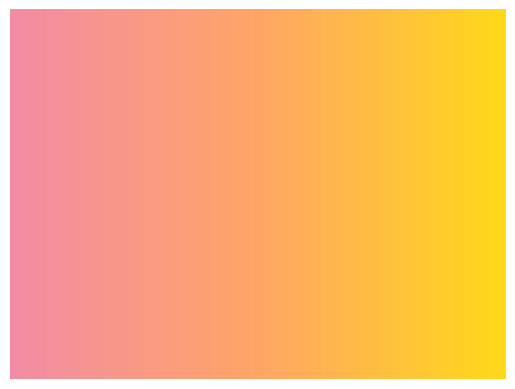

In [76]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    (0.95, 0.55, 0.65), # warm pastel pink
    (1.0, 0.65, 0.4),   # soft orange
    (1.0, 0.85, 0.1),   # rich pastel yellow
]


pastel_magenta_seq = LinearSegmentedColormap.from_list("pastel_magenta_seq", colors)

gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, aspect='auto', cmap=pastel_magenta_seq)
plt.axis('off')
plt.show()

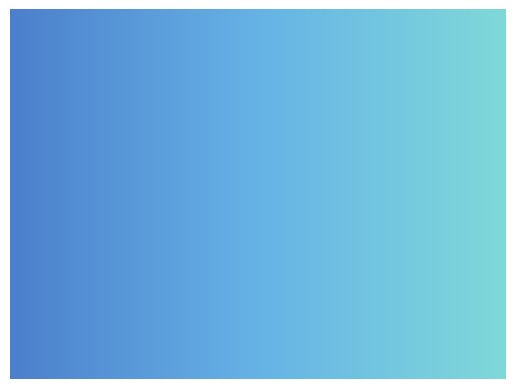

In [77]:
colors_teal_blue = [
    (0.3, 0.5, 0.8),    # deeper cornflower blue
    (0.4, 0.7, 0.9),    # light blue
    (0.5, 0.85, 0.85),  # soft cyan
]

cool_teal_blue = LinearSegmentedColormap.from_list("cool_teal_blue", colors_teal_blue)

gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, aspect='auto', cmap=cool_teal_blue)
plt.axis('off')
plt.show()

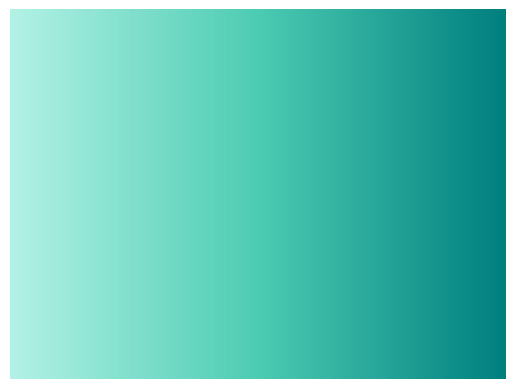

In [72]:
colors_teal = [
    (0.7, 0.95, 0.9),   # pale turquoise
    (0.3, 0.8, 0.7),    # medium jade
    (0.0, 0.5, 0.5),    # deep teal
]
soft_green_seq = LinearSegmentedColormap.from_list("soft_green_seq", colors_teal)
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, aspect='auto', cmap=soft_green_seq)
plt.axis('off')
plt.show()

## plot with human mean level or richness 

/tmp/ipykernel_363200/1648649587.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


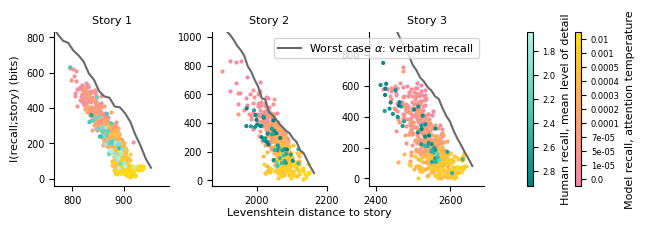

In [137]:
fig = plt.figure(figsize = (6.8,2))
gs = GridSpec(1, 5, width_ratios=[1, 1, 1, 0.05, 0.05], wspace=0.6,hspace=0.3)
plot_fontsize = 8

# Define the discrete colormap and bounds based on the number of scales in model
n_scales = len(scales)
cmap_model = pastel_magenta_seq #plt.cm.RdPu_r #plt.cm.YlGn # for model recall
cmap_human = soft_green_seq #'Greens'# 'RdPu_r'
color_verbatim = 'dimgray'
bounds = np.arange(n_scales + 1)
norm = mcolors.BoundaryNorm(bounds, cmap_model.N)

# for human colors
vmin = np.percentile(np.abs(all_human_mean_value), 3)
vmax = np.percentile(np.abs(all_human_mean_value), 100-3)

for i,story in enumerate(stories[:3]):
    ax = fig.add_subplot(gs[i])
    filtered_model_recall_transcript = all_stories_model_recall_transcript[story]
    story_rd_dict = all_stories_rd_dict[story]
    # Scatter plot using index-based color values for the 'Blues' colormap
    for idx, s in enumerate(scales):
        indices = np.where(filtered_model_recall_transcript['scale'] == s)[0]
        ax.scatter(story_rd_dict['model_levenshtein_d'][indices], story_rd_dict['model_recall_explained_story_info'][indices], 
                    color=cmap_model(norm(idx)), label=s,s=4)

    # human
    if 'human_mean_level' in story_rd_dict:
        color_vals = story_rd_dict['human_mean_level']
        human_scatter = ax.scatter(story_rd_dict['human_levenshtein_d'],story_rd_dict['human_recall_explained_story_info'],
                c = color_vals,cmap = cmap_human,vmin=vmin,vmax=vmax,s=4)
    else:
        human_scatter = ax.scatter(story_rd_dict['human_levenshtein_d'],story_rd_dict['human_recall_explained_story_info'],
                color = 'black',vmin=vmin,vmax=vmax,s=4)

    min_ce_diff = np.min(np.concatenate([story_rd_dict['human_recall_explained_story_info'],story_rd_dict['model_recall_explained_story_info']]))
    max_ce_diff = np.max(np.concatenate([story_rd_dict['human_recall_explained_story_info'],story_rd_dict['model_recall_explained_story_info']]))

    # verbatim recall
    min_d = np.min(np.concatenate([story_rd_dict['model_levenshtein_d'],story_rd_dict['human_levenshtein_d']]))
    max_d = np.max(np.concatenate([story_rd_dict['model_levenshtein_d'],story_rd_dict['human_levenshtein_d']]))
    line, = ax.plot(story_rd_dict['verbatim_levenshtein_d'],story_rd_dict['verbatim_recall_explained_story_info'],
                    color = color_verbatim,label = r'Worst case $\alpha$: verbatim recall',
                    )
    ax.set_ylim([min_ce_diff-50,max_ce_diff+200])
    ax.set_xlim([min_d-30,max_d+50])
    ax.set_title('Story '+str(story_to_idx_mapping[story]),fontsize = plot_fontsize)
    if i == 2:
        plt.legend(handles=[line], loc='upper right',fontsize = plot_fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=plot_fontsize-1)
    ax.tick_params(axis='y', labelsize=plot_fontsize-1)

# Add color bars to the right of the third plot
cax1 = fig.add_subplot(gs[3])
cbar1 = fig.colorbar(human_scatter, cax=cax1)
cbar1.set_label(label='Human recall, mean level of detail', fontsize=plot_fontsize)
cbar1.ax.invert_yaxis()  # Flip the colorbar upside down
cax1.tick_params(axis='both', labelsize=plot_fontsize-2)

cax2 = fig.add_subplot(gs[4])
# Create the discrete colorbar for model colormap
sm = plt.cm.ScalarMappable(cmap=cmap_model, norm=norm)
sm.set_array([])  # dummy array for the colorbar
cbar2 = fig.colorbar(sm, cax=cax2)
#cbar = fig.colorbar(sm, ticks=np.arange(n_scales) + 0.5,pad=0.3)
cbar2.set_label('Model recall, attention temperature', fontsize=plot_fontsize)
cbar2.set_ticks(np.arange(n_scales) + 0.5)
cbar2.set_ticklabels(scales)
cax2.tick_params(axis='both', labelsize=plot_fontsize-2)
#cbar2.ax.invert_yaxis()  # Flip the colorbar upside down

plt.tight_layout()
fig.supxlabel('Levenshtein distance to story',fontsize = plot_fontsize,y = -0.05,x=0.5)
fig.supylabel('I(recall;story) (bits)',fontsize = plot_fontsize,x=0.06)
#fig.suptitle('Levenshtein distance vs. I(recall;story), model and human recalls',fontsize = 25) 


#plt.savefig(os.path.join(rate_distortion_dir,"rate_distortion_plot_3_stories.svg"), transparent=True)
plt.show()

## plot with attention entropy for humans 

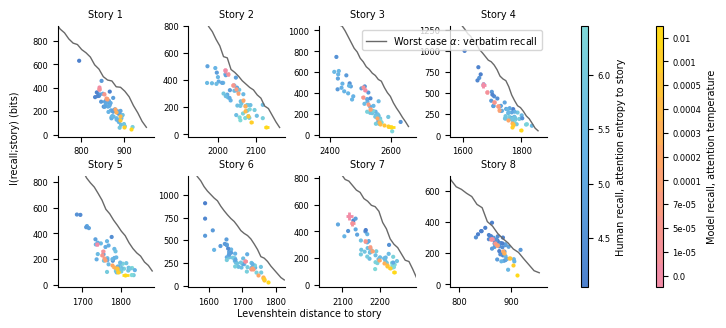

In [142]:
plot_fontsize = 7
fig = plt.figure(figsize = (6.8,3.4))
gs = GridSpec(2, 7, figure=fig, width_ratios=[1, 1, 1, 1, 0.07,0.000000001, 0.07], wspace=0.6,hspace=0.35,left=0.01)

# Define the discrete colormap and bounds based on the number of scales in model
n_scales = len(scales)
cmap_model = pastel_magenta_seq # for model recall # used to be RdPu_r
cmap_human = cool_teal_blue #sns.cubehelix_palette(start=2.8, rot=0.1, as_cmap=True,light = 0.85)#sns.cubehelix_palette(start=1.5, rot=0.3, as_cmap=True,light = 0.85,reverse=True) # 'RdPu_r' # used to be Blues
color_verbatim = 'dimgray'
bounds = np.arange(n_scales + 1)
norm = mcolors.BoundaryNorm(bounds, cmap_model.N)

# for human colors
vmin = np.percentile(np.abs(all_human_attention_entropy), 3)
vmax = np.percentile(np.abs(all_human_attention_entropy), 100-3)

for i,story in enumerate(stories):
    plot_row = int(np.floor(i/4))
    plot_col = int(i%4)
    ax = fig.add_subplot(gs[plot_row, plot_col])
    filtered_model_recall_transcript = all_stories_model_recall_transcript[story]
    story_rd_dict = all_stories_rd_dict[story]
    # Scatter plot 
    story_mean_model_recall_explained_story_info = []
    story_mean_model_levenshtein_d = []
    for idx, s in enumerate(scales):
        indices = np.where(filtered_model_recall_transcript['scale'] == s)[0]
        this_model_recall_explained_story_info = story_rd_dict['model_recall_explained_story_info'][indices]
        this_model_levenshtein_d = story_rd_dict['model_levenshtein_d'][indices]
        mean_model_recall_explained_story_info = np.mean(this_model_recall_explained_story_info)
        mean_model_levenshtein_d = np.mean(this_model_levenshtein_d)
        se_model_recall_explained_story_info = stats.sem(this_model_recall_explained_story_info)
        se_model_levenshtein_d = stats.sem(this_model_levenshtein_d)
        ax.errorbar(mean_model_levenshtein_d, mean_model_recall_explained_story_info, 
                    xerr = se_model_levenshtein_d, yerr = se_model_recall_explained_story_info,
                    fmt = '.',
                    color=cmap_model(norm(idx)), label=s,ms = 4,elinewidth=2)
        story_mean_model_recall_explained_story_info.append(mean_model_recall_explained_story_info)
        story_mean_model_levenshtein_d.append(mean_model_levenshtein_d)

    # human
    color_vals = story_rd_dict['human_attention_entropy']
    human_scatter = ax.scatter(story_rd_dict['human_levenshtein_d'],story_rd_dict['human_recall_explained_story_info'],
                c = color_vals,cmap = cmap_human,vmin=vmin,vmax=vmax,s = 4)


    min_ce_diff = np.min(np.concatenate([story_rd_dict['human_recall_explained_story_info'],story_mean_model_recall_explained_story_info]))
    max_ce_diff = np.max(np.concatenate([story_rd_dict['human_recall_explained_story_info'],story_mean_model_recall_explained_story_info]))

    # verbatim recall
    min_d = np.min(np.concatenate([story_mean_model_levenshtein_d,story_rd_dict['human_levenshtein_d']]))
    max_d = np.max(np.concatenate([story_mean_model_levenshtein_d,story_rd_dict['human_levenshtein_d']]))
    line, = ax.plot(story_rd_dict['verbatim_levenshtein_d'],story_rd_dict['verbatim_recall_explained_story_info'],
                    color = color_verbatim,label = r'Worst case $\alpha$: verbatim recall',lw=1
                    )

    ax.set_ylim([-20,max_ce_diff+300])
    ax.set_xlim([min_d-50,max_d+50])
    ax.set_title('Story '+str(story_to_idx_mapping[story]),fontsize = plot_fontsize)
    if i == 3:
        plt.legend(handles=[line], loc='upper right',fontsize = plot_fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=plot_fontsize-1)

# Add color bars to the right, spanning both rows
cax1 = fig.add_subplot(gs[:, 4])
cbar1 = fig.colorbar(human_scatter, cax=cax1)
cbar1.set_label(label='Human recall, attention entropy to story', fontsize=plot_fontsize)
cax1.tick_params(axis='both', labelsize=plot_fontsize-1)

cax2 = fig.add_subplot(gs[:, 6])
# Create the discrete colorbar for model colormap
sm = plt.cm.ScalarMappable(cmap=cmap_model, norm=norm)
sm.set_array([])  # dummy array for the colorbar
cbar2 = fig.colorbar(sm, cax=cax2)
#cbar = fig.colorbar(sm, ticks=np.arange(n_scales) + 0.5,pad=0.3)
cbar2.set_label('Model recall, attention temperature', fontsize=plot_fontsize)
cbar2.set_ticks(np.arange(n_scales) + 0.5)
cbar2.set_ticklabels(scales)
cax2.tick_params(axis='both', labelsize=plot_fontsize-1)

fig.supxlabel('Levenshtein distance to story',fontsize = plot_fontsize,y = 0.02,x=0.38)
fig.supylabel('I(recall;story) (bits)',fontsize = plot_fontsize,y=0.55,x=-0.06)
#fig.suptitle('Levenshtein distance vs. I(recall;story), model and human recalls',fontsize = 25) 
#fig.subplots_adjust(wspace=0.7, hspace=0.7)


plt.savefig(os.path.join(rate_distortion_dir,"rate_distortion_plot_all_stories_attention_entropy_mean_across_model.svg"), transparent=True)
plt.show()

In [145]:
for story in stories:
    print(story)
    with open(os.path.join(rate_distortion_dir,'%s_rd_plot_dict.pkl'%story),'rb') as f:
        story_rd_dict = pickle.load(f)
    print('Levenshtein D with attention entropy',stats.pearsonr(story_rd_dict['human_levenshtein_d'],story_rd_dict['human_attention_entropy']))
    if 'human_mean_level' in story_rd_dict:
        print('I(X;R) with mean level',stats.pearsonr(story_rd_dict['human_recall_explained_story_info'],story_rd_dict['human_mean_level']))
        print('Levenshtein D with mean level',stats.pearsonr(story_rd_dict['human_levenshtein_d'],story_rd_dict['human_mean_level']))
    
    print('----------------------------')

pieman
Levenshtein D with attention entropy PearsonRResult(statistic=0.8042622943244819, pvalue=1.1750593383854919e-12)
I(X;R) with mean level PearsonRResult(statistic=0.652552724578028, pvalue=2.117200914873352e-07)
Levenshtein D with mean level PearsonRResult(statistic=-0.6207300331593598, pvalue=1.178095704415174e-06)
----------------------------
alternateithicatom
Levenshtein D with attention entropy PearsonRResult(statistic=0.5709337284156399, pvalue=2.7814015766694382e-05)
I(X;R) with mean level PearsonRResult(statistic=0.5613995123611193, pvalue=4.0368112956995466e-05)
Levenshtein D with mean level PearsonRResult(statistic=-0.46535833907501745, pvalue=0.0009806341376362533)
----------------------------
odetostepfather
Levenshtein D with attention entropy PearsonRResult(statistic=0.4475878877282029, pvalue=0.0020500938340995956)
I(X;R) with mean level PearsonRResult(statistic=0.6742511750217992, pvalue=3.819995293158984e-07)
Levenshtein D with mean level PearsonRResult(statistic=

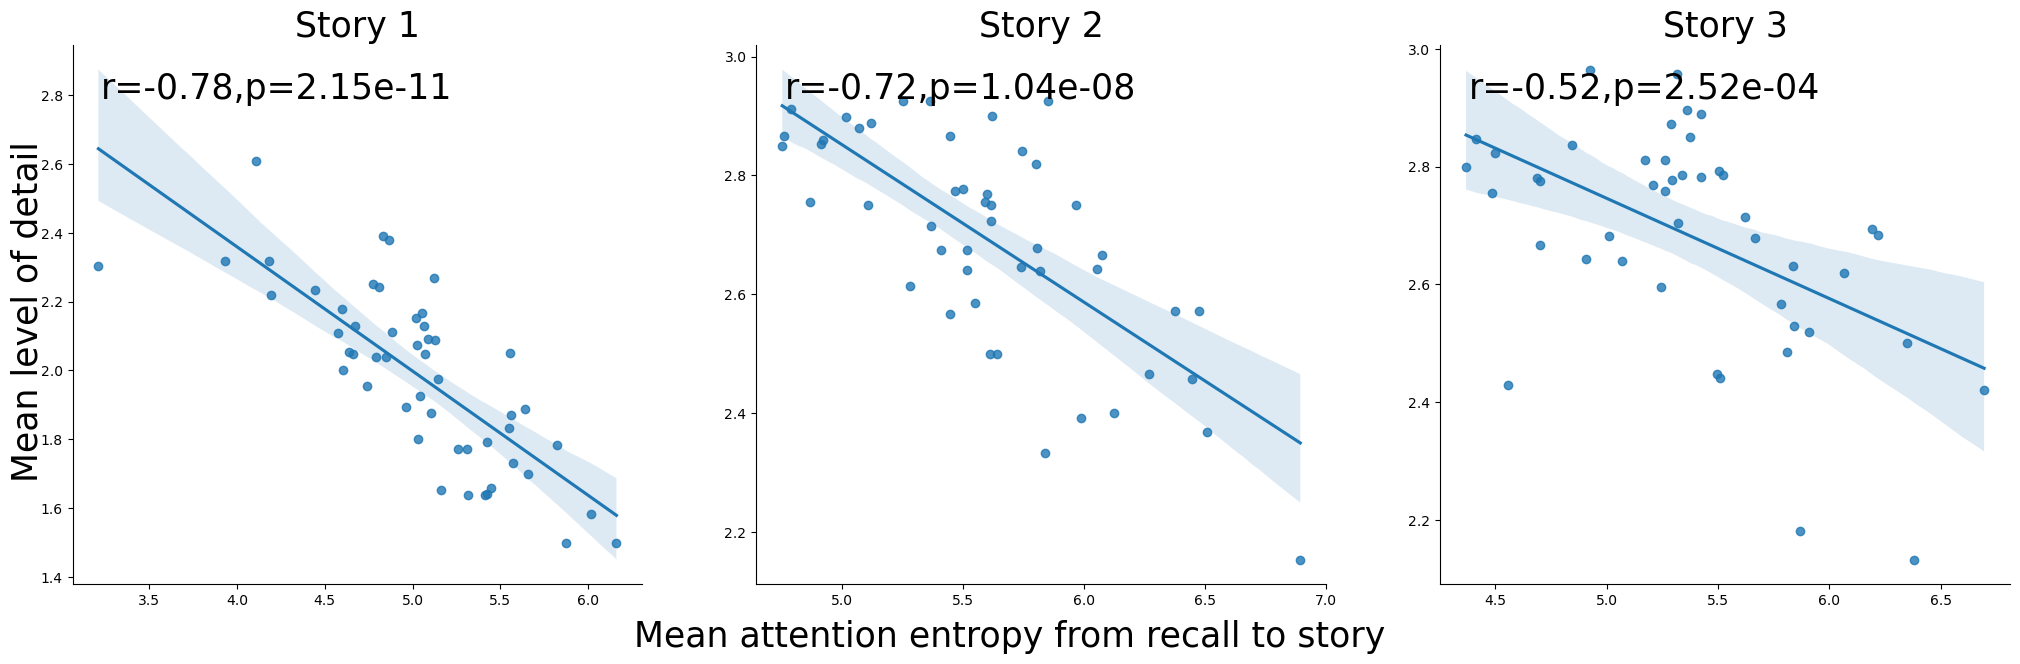

In [41]:
fig,axes = plt.subplots(1,3,figsize = (25,7))
for i,(story,ax) in enumerate(zip(stories,axes)):
    story_rd_dict = all_stories_rd_dict[story]
    if 'human_mean_level' in story_rd_dict:
        sns.regplot(x=story_rd_dict['human_attention_entropy'],y=story_rd_dict['human_mean_level'],ax=ax)
        r,pval = stats.pearsonr(story_rd_dict['human_mean_level'],story_rd_dict['human_attention_entropy'])
        ax.text(0.05, 0.95, 'r=%.2f,p=%.2e'%(r,pval), ha='left', va='top', transform=ax.transAxes,fontsize =25)
        ax.set_title('Story '+str(story_to_idx_mapping[story]),fontsize = 25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
fig.supxlabel('Mean attention entropy from recall to story',fontsize =25)
fig.supylabel('Mean level of detail',x = 0.1,fontsize = 25)
fig.savefig(os.path.join(rate_distortion_dir,"mean_level_vs_attention_entropy.svg"), transparent=True)

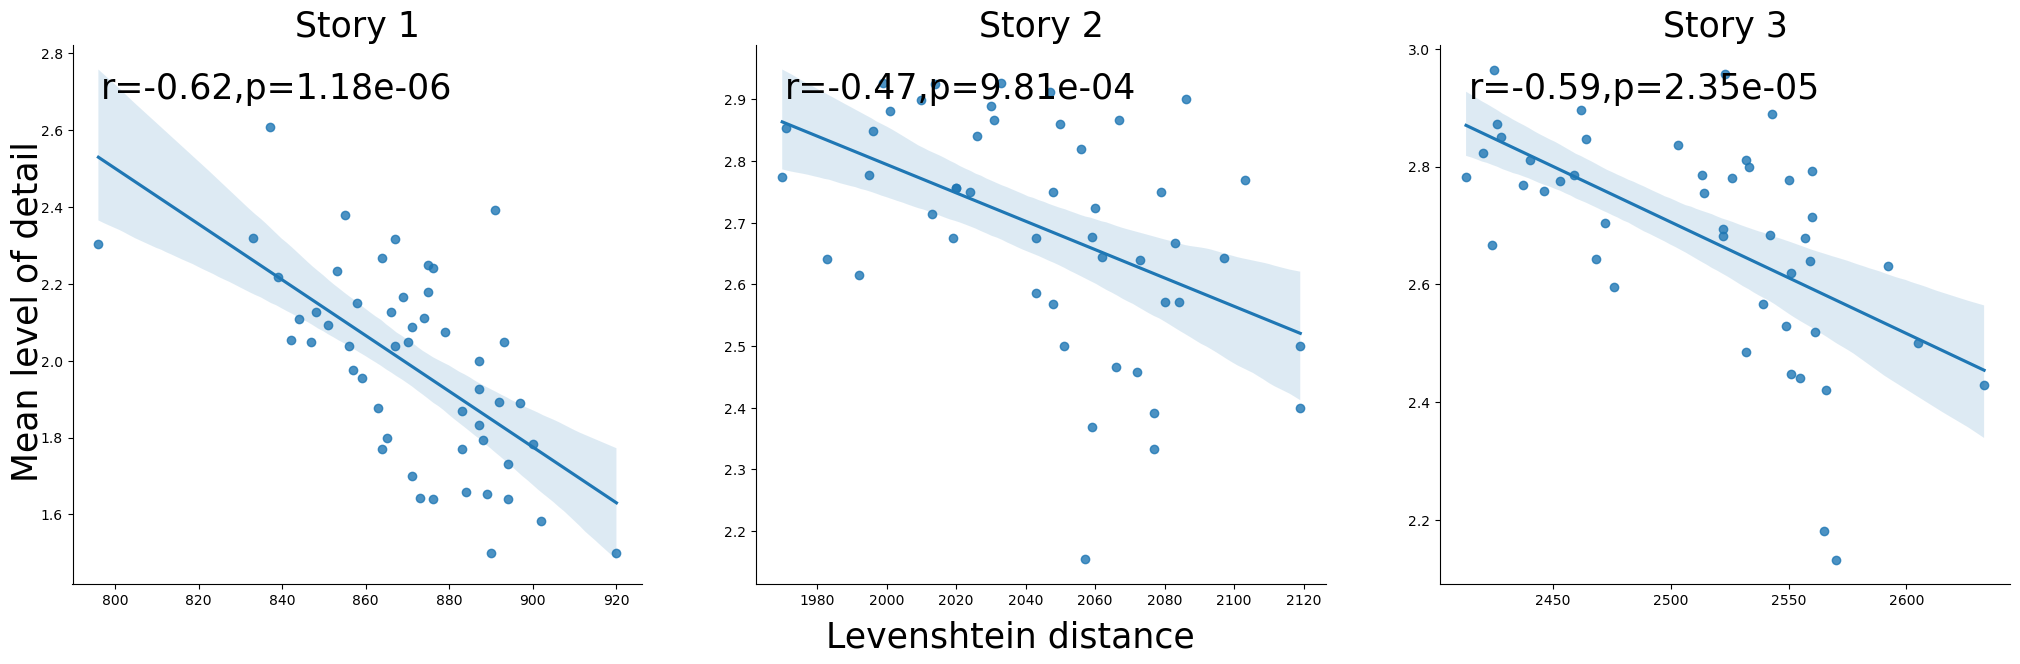

In [46]:
fig,axes = plt.subplots(1,3,figsize = (25,7))
for i,(story,ax) in enumerate(zip(stories,axes)):
    story_rd_dict = all_stories_rd_dict[story]
    if 'human_mean_level' in story_rd_dict:
        sns.regplot(x=story_rd_dict['human_levenshtein_d'],y=story_rd_dict['human_mean_level'],ax=ax)
        r,pval = stats.pearsonr(story_rd_dict['human_mean_level'],story_rd_dict['human_levenshtein_d'])
        ax.text(0.05, 0.95, 'r=%.2f,p=%.2e'%(r,pval), ha='left', va='top', transform=ax.transAxes,fontsize =25)
        ax.set_title('Story '+str(story_to_idx_mapping[story]),fontsize = 25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
fig.supylabel('Mean level of detail',x = 0.1,fontsize =25)
fig.supxlabel('Levenshtein distance',fontsize = 25)
fig.savefig(os.path.join(rate_distortion_dir,"mean_level_vs_levenshtein_d.svg"), transparent=True)

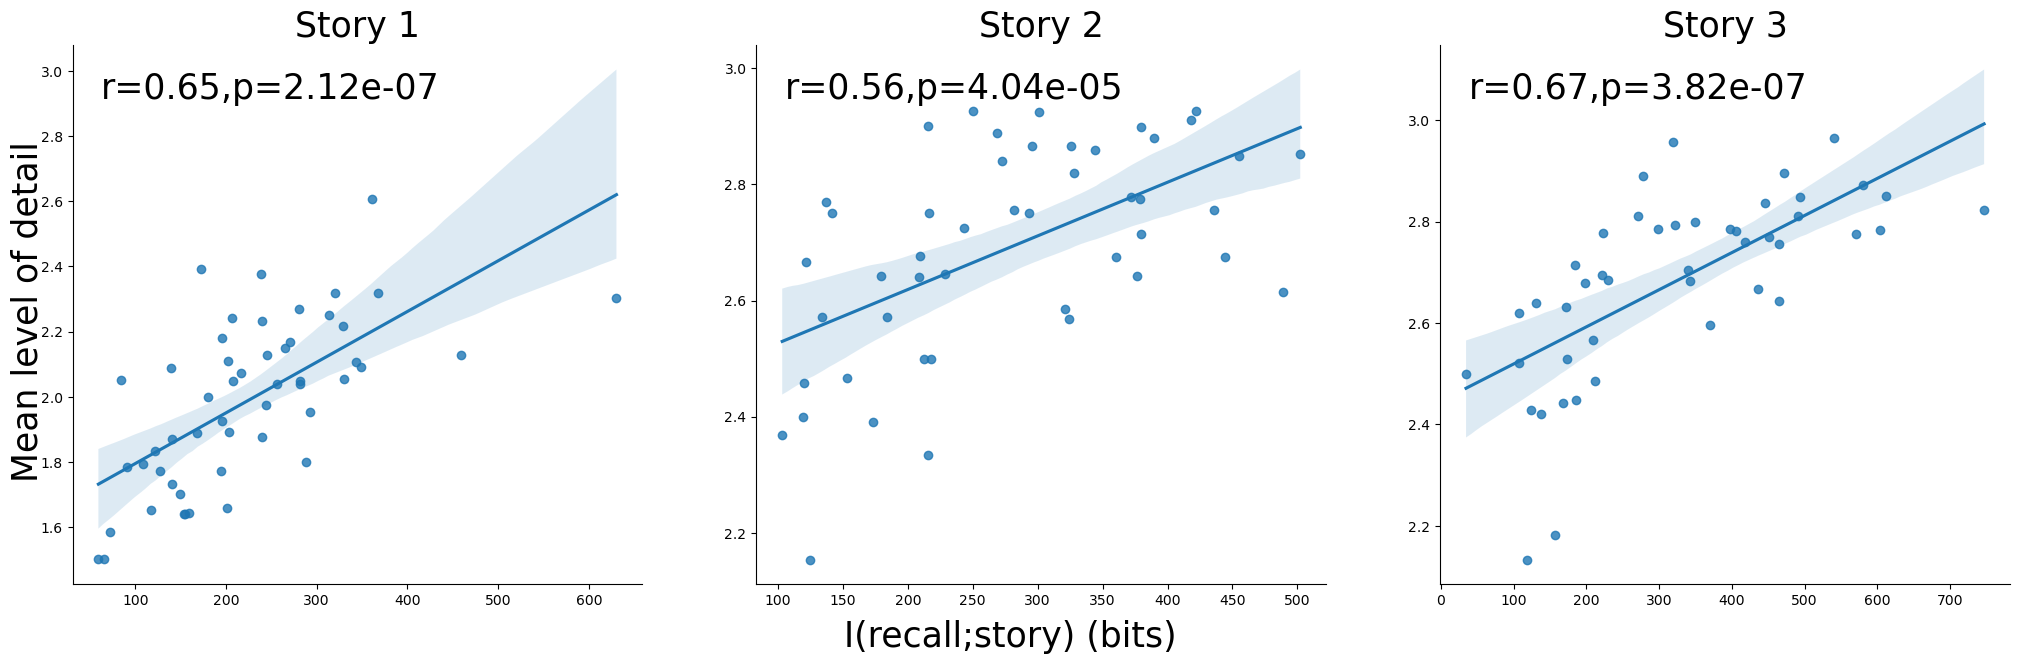

In [42]:
fig,axes = plt.subplots(1,3,figsize = (25,7))
for i,(story,ax) in enumerate(zip(stories,axes)):
    story_rd_dict = all_stories_rd_dict[story]
    if 'human_mean_level' in story_rd_dict:
        sns.regplot(x=story_rd_dict['human_recall_explained_story_info'],y=story_rd_dict['human_mean_level'],ax=ax)
        r,pval = stats.pearsonr(story_rd_dict['human_mean_level'],story_rd_dict['human_recall_explained_story_info'])
        ax.text(0.05, 0.95, 'r=%.2f,p=%.2e'%(r,pval), ha='left', va='top', transform=ax.transAxes,fontsize =25)
        ax.set_title('Story '+str(story_to_idx_mapping[story]),fontsize = 25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
fig.supylabel('Mean level of detail',x = 0.1,fontsize =25)
fig.supxlabel('I(recall;story) (bits)',fontsize = 25)
fig.savefig(os.path.join(rate_distortion_dir,"mean_level_vs_recall_explained_story_info.svg"), transparent=True)

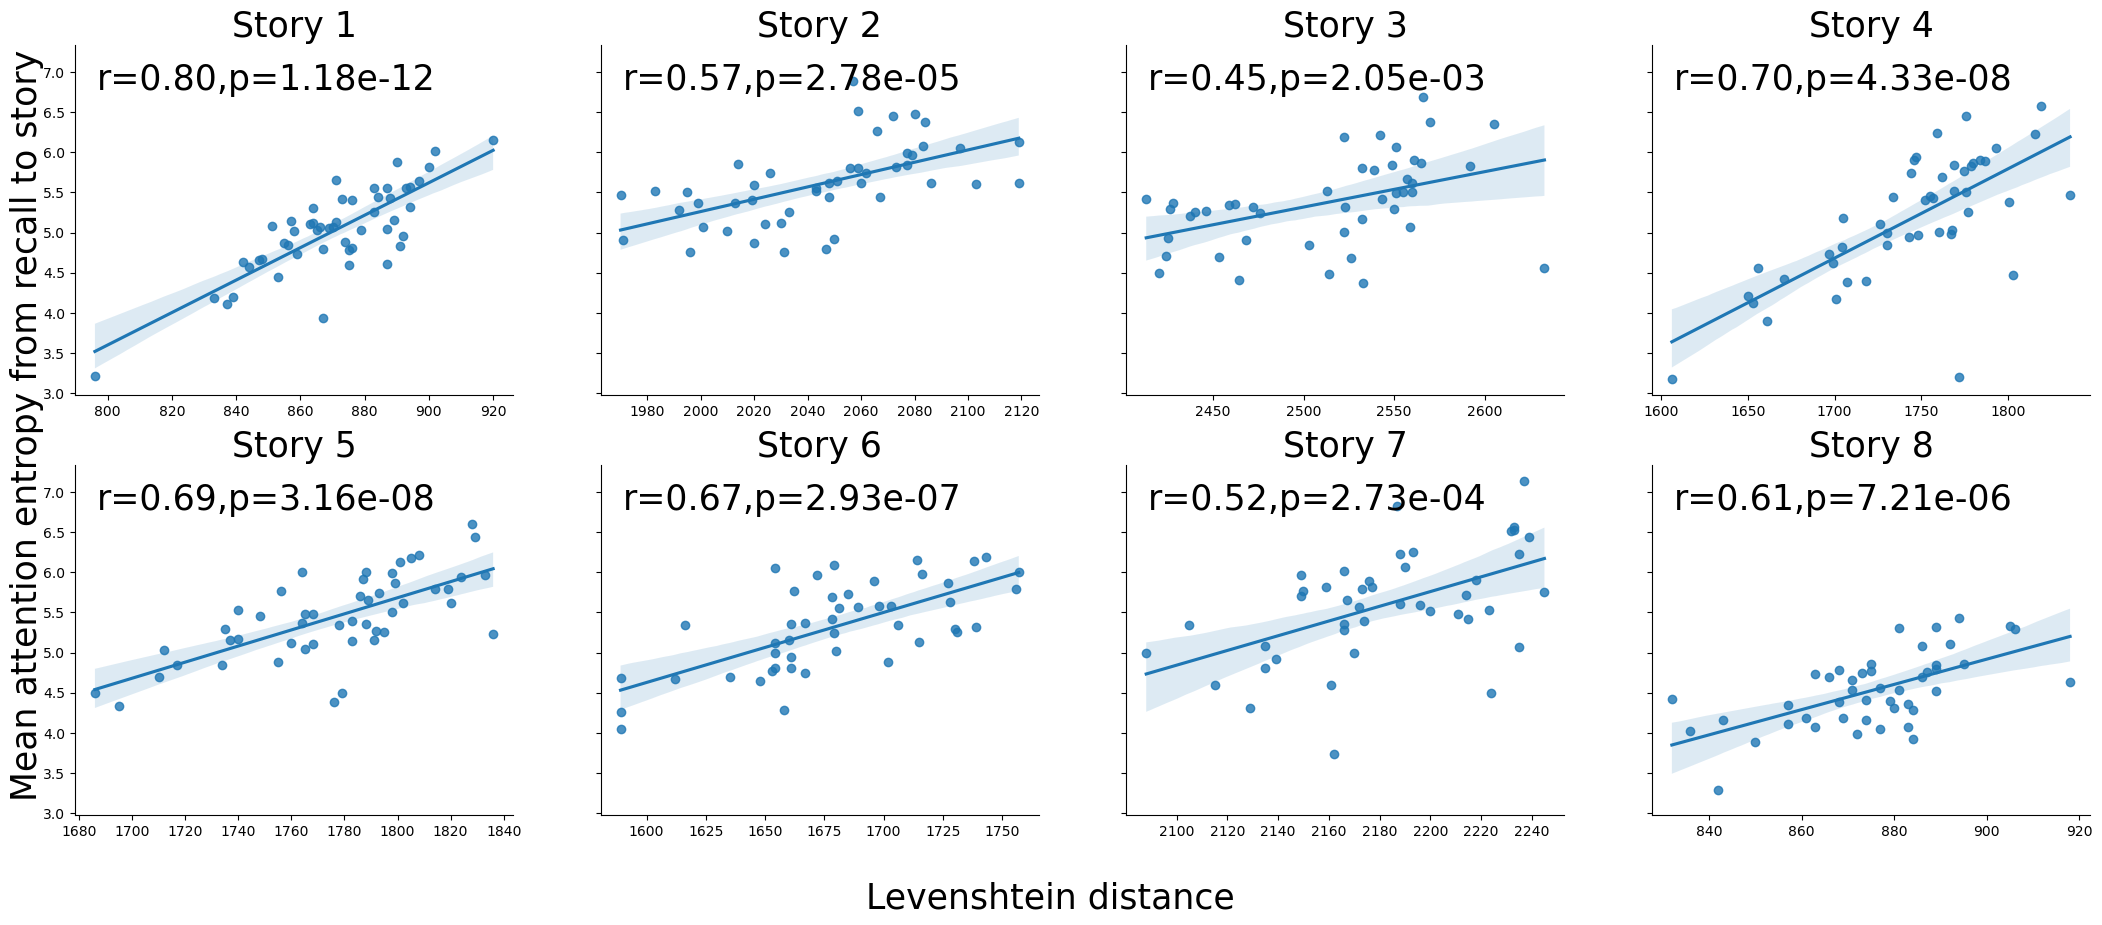

In [43]:
fig,axes = plt.subplots(2,4,figsize = (26,10),sharey=True)
for i,(story,ax) in enumerate(zip(stories,axes.flatten())):
    story_rd_dict = all_stories_rd_dict[story]
    sns.regplot(x=story_rd_dict['human_levenshtein_d'],y=story_rd_dict['human_attention_entropy'],ax = ax)
    r,pval = stats.pearsonr(story_rd_dict['human_levenshtein_d'],story_rd_dict['human_attention_entropy'])
    ax.text(0.05, 0.95, 'r=%.2f,p=%.2e'%(r,pval), ha='left', va='top', transform=ax.transAxes,fontsize =25)
    ax.set_title('Story '+str(story_to_idx_mapping[story]),fontsize = 25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
fig.supxlabel('Levenshtein distance',fontsize =25)
fig.supylabel('Mean attention entropy from recall to story',x = 0.1,fontsize = 25)
fig.savefig(os.path.join(rate_distortion_dir,"attention_entropy_vs_levenshtein_d.svg"), transparent=True)

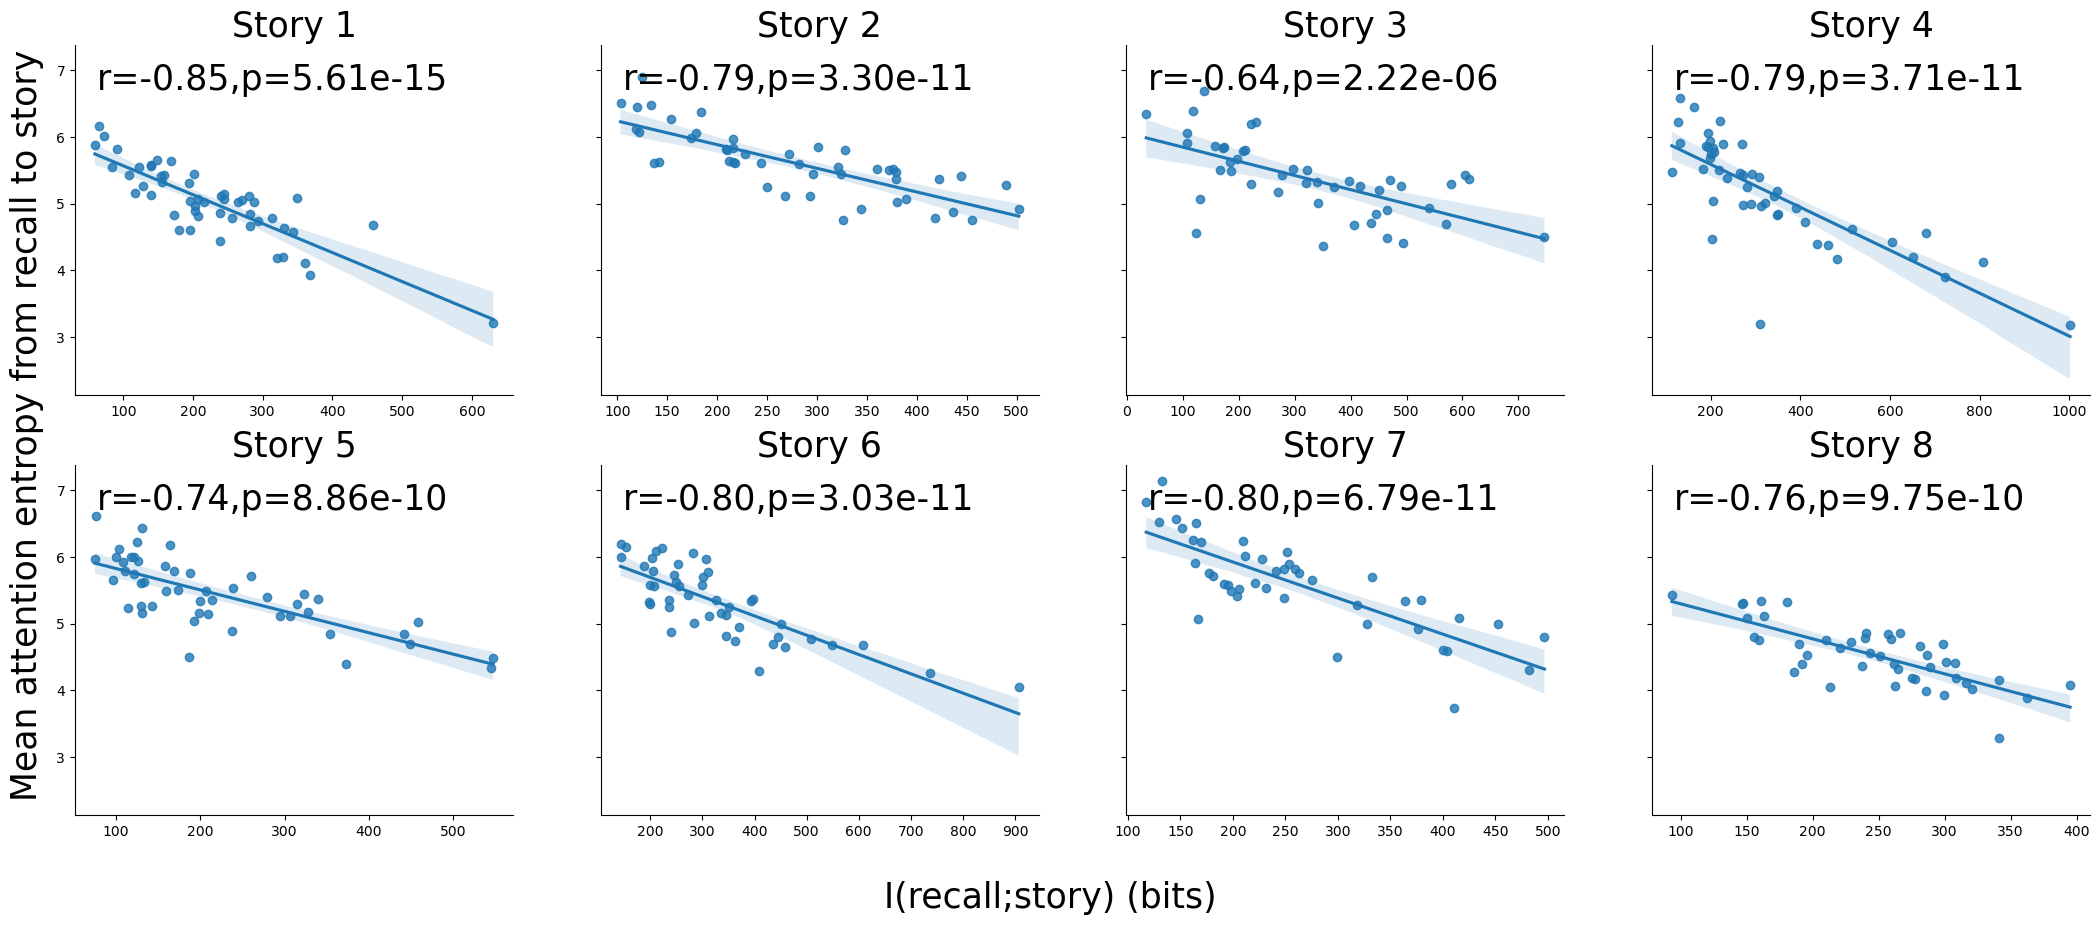

In [44]:
fig,axes = plt.subplots(2,4,figsize = (26,10),sharey=True)
for i,(story,ax) in enumerate(zip(stories,axes.flatten())):
    story_rd_dict = all_stories_rd_dict[story]
    sns.regplot(x=story_rd_dict['human_recall_explained_story_info'],y=story_rd_dict['human_attention_entropy'],ax=ax)
    r,pval = stats.pearsonr(story_rd_dict['human_recall_explained_story_info'],story_rd_dict['human_attention_entropy'])
    ax.text(0.05, 0.95, 'r=%.2f,p=%.2e'%(r,pval), ha='left', va='top', transform=ax.transAxes,fontsize =25)
    ax.set_title('Story '+str(story_to_idx_mapping[story]),fontsize = 25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.supxlabel('I(recall;story) (bits)',fontsize =25)
fig.supylabel('Mean attention entropy from recall to story',x = 0.1,fontsize = 25)
fig.savefig(os.path.join(rate_distortion_dir,"attention_entropy_vs_recall_explained_story_info.svg"), transparent=True)